We want to examine linear spreading speeds, in this case, on the line graph, for small $p = O(\epsilon)$. This is largely a modification of the Bakhshi survey.

In [1]:
# Importin my needed libraries
import numpy as np 
from matplotlib import pyplot as plt
import networkx as nx
import DynaNet
import Equations
%matplotlib notebook

from numpy import linalg

<IPython.core.display.Javascript object>


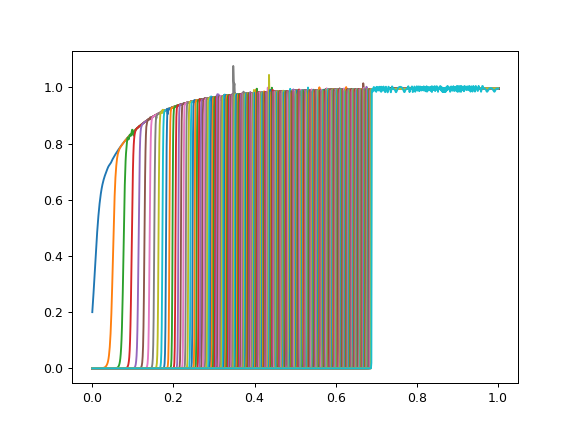

In [50]:
# Set graph parameters
graph_size = 300

# Line graphs
ident = np.identity(graph_size)
adj = np.roll(ident, 1) + np.roll(ident, -1) 
adj[0, 0] = 0
adj[graph_size-1, graph_size-1] = 0
online, offline = adj, adj
#print(adj)

# Create a multiplexed dynamic graph model
MG = DynaNet.MultiplexDynaNet([online, offline])
MG.generate_incidence()
MG.generate_laplacian()
MG.generate_multi_laplacian()

# Set up our multiplexed Fisher-KPP equation
MDE = Equations.MultiplexFisherKPPStep

# Set up equation parameters
ks = np.array([-0.001 for ii in range(graph_size)] + [-20 for ii in range(graph_size)])
vs = np.zeros(2*graph_size)
epsilon = 0.1

def coupling(state):
    p = 0
    omega = 100
    alpha, theta = 1, 1
    gamma = 1000
    beta = 20
    u = state[:graph_size]
    v = state[graph_size:]
    u_next = omega*(-u + gamma*u*(1-u)/(1+np.exp(-beta*(v-alpha))))
    v_next = 1-v*theta*(1+u)**p
    return np.concatenate((u_next, v_next))

# Set up initial conditions
t0 = 0
tf = 1
nt = 1000
A, k, B = 0.2, 10, .7
u0 = A*np.exp(-k*np.arange(graph_size))
v0 = B*np.ones(graph_size)
f0 = np.concatenate((u0, v0))

# Run simulation
MG.solve_ivp(MDE, f0, t0, tf, nt, ks, vs, coupling)
res = MG.solve_ivp_results

for ii in range(graph_size):
    plt.plot(res.t, res.y[ii, :], label=f'{ii}')
    #plt.legend()


To get a better idea of what exactly is going on with the strangely osccilating noise, let's explode the view.

<IPython.core.display.Javascript object>


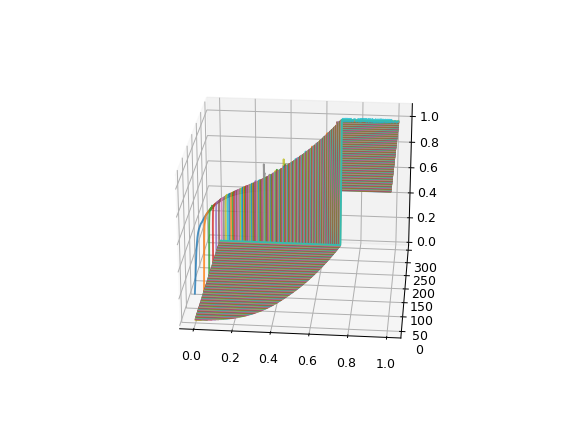

In [51]:
from mpl_toolkits.mplot3d import axes3d

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
y_ticks = list(range(graph_size))
for ii in y_ticks:    
    ax.plot(res.t, res.y[ii, :], zs=ii, zdir='y', alpha=0.8)

<IPython.core.display.Javascript object>


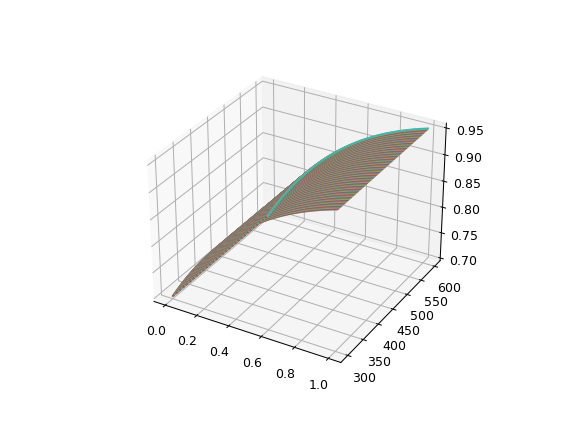

In [52]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
y_ticks = list(range(graph_size, 2 * graph_size))
for ii in y_ticks:    
    ax.plot(res.t, res.y[ii, :], zs=ii, zdir='y', alpha=0.8)

Lets focus on the $u$ field, or the social tension. For small $p$, the social unrest, $v$ is nearly decoupled from $u$. Recall, that for $p=0$, if $\frac{\Gamma}{2}-\omega < 0$, then our linear spreading speed can not be defined, but we may still be able to define a selected spreading speed through thresholding.

In [36]:
def get_numeric_spreading_speed(time_results, spatial_results, thresh):
    # Take only u values from the combined vector
    u_vec = spatial_results[:graph_size, :]
    
    # Determine at which times the u is above the threshold value
    u_thresh = u_vec > thresh
    
    # Get first arriaval index from each column. Distances already in order
    first_indicies = np.argmax(u_thresh, axis=1)
    
    # Get corresponding first time
    first_times = time_results[first_indicies]
    
    return first_times
    

<IPython.core.display.Javascript object>


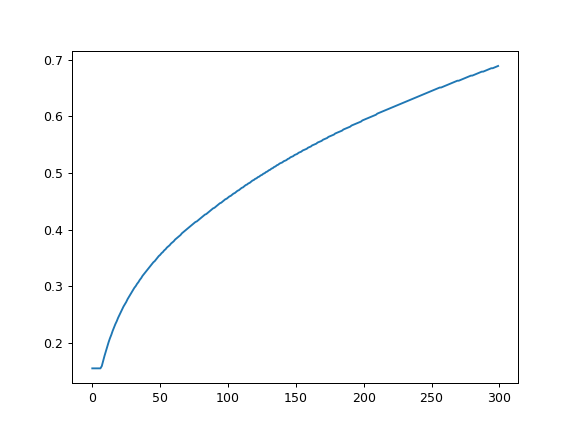

In [53]:
first_times = get_numeric_spreading_speed(res.t, res.y, 0.9)
plt.plot(first_times)

## Comparison to Theory

Lets begin by looking at what Theory might suggest. Consider the unperturbed case where $p=0$ and $v$ is decoupled from $u$. Allowing $v$ to exhibit fast diffusion and equillibrate to $v^* = \mathbf{1}$, we can observe $u$ to simply follow

$$
\dot{\mathbf{u}} =  d_1 \nabla_{G}^2 \mathbf{u} + r(\mathbf{1})\mathbf{u}(\mathbf{1}-\mathbf{u})-\omega \mathbf{u} = d_1 \nabla_{G}^2 \mathbf{u} + \frac{\Gamma}{2}\mathbf{u}(\mathbf{1}-\mathbf{u})-\omega \mathbf{u}
$$

If we consider an infinite line graph, $G$, and selecting an arbitrary starting point, labeling it $u_0$, the set of equations are simply 

$$
\dot{u_j} = d_1(u_{j+1} + u_{j-1} - 2u_{j}) + \frac{\Gamma}{2}u_j(1-u_j) - \omega u_j
$$

Using the standard ansatz, $u_j = e^{\lambda t - \gamma j}$, our equation reads

$$
\lambda = d_1(e^{-\gamma} + e^{\gamma} - 2) \frac{\Gamma}{2}(1-e^{\lambda t - \gamma n}) - \omega
$$

Linearizing about $\mathbf{0}$ (which should be reasonable for the exponential decay ansatz) gives

$$
\lambda = d_1(e^{-\gamma} + e^{\gamma} - 2) + \frac{\Gamma}{2} - \omega 
$$

Boosting into a reference frame, $s\gamma$ gives

$$
d_{s_l}(0, \gamma_l) = 0 = d_1(-2+e^{\gamma_l} + e^{\gamma_l}) + \frac{\Gamma}{2} -\omega - s_l \gamma_l \\
\partial_{\gamma}d_{s_l}(0, \gamma_l) = 0 = d_1(e^{\gamma_l}-e^{-\gamma_l}) - s_l
$$

The roots can be found via rootsolve

In [54]:
from scipy.optimize import root

# set up functions for rootsolving

# Function to rootfind, may take in additions paramters
def pinched_double_root_find(x, d1, Gamma, omega):
    """
    x: (s, \gamma) pair
    d1: diffusion coeff
    Gamma: big gamma from Bakhshi
    omega: damping from Bakhshi
    """
    
    # unpack
    s, gamma = x[0], x[1]
    
    # solve for the root (root) and pinched root (root_der) conditions
    root = d1 * (-2 + np.exp(-gamma) + np.exp(gamma)) + Gamma / 2 - omega - s * gamma
    root_der = d1 * (-np.exp(-gamma) + np.exp(gamma)) - s
    
    return (root, root_der)

# compare with simulated parameters
omega = 100
Gamma = 100000
d1 = 0.001

# initial guess will just be what we estimated from the simulation
s0 = 460
g0 = np.arcsinh(2*sl/d1)

# solve the root
sol = root(pinched_double_root_find, np.array([s0, g0]), args=(d1, Gamma, omega))
s_true, g_true = sol.x
print(s_true, g_true)

3543.8515459800383 15.080724700950416


- Keep with teh weak p dependence
- Will the pulse, if smaller, propogate under
- Do a parameter Survey for smaller $\Gamma$

In [9]:
gl

14.425276129585464